[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nagocs/birdclef-challenge/blob/main/data_visualisation.ipynb)

# BirdCLEF - Adatfeldolgozás

## Könyvtárak importálása

A BirdCLEF (madárhang-felismerő) projekt előkészítő szakaszához szükséges **könyvtárakat** importáljuk.

In [ ]:
# Importok
# Rendszer
import os  # Operációs rendszerrel való műveletekhez (pl. fájlkezelés, útvonalak)
from glob import glob  # Fájlrendszerben való fájlkeresés minták alapján

# Adatkezelés
import numpy as np  # Numerikus számításokhoz, tömbműveletekhez
import pandas as pd  # Táblázatos adatok kezelésére (DataFrame formátumban)

# Deep Learning
import keras_cv  # Keras Computer Vision kiterjesztés (képfeldolgozáshoz, augmentációhoz)
import keras  # Keras neurális hálózatok építéséhez és tanításához
import tensorflow as tf  # TensorFlow – a Keras alapjául szolgáló mélytanulási keretrendszer

# Kép- és hangfeldolgozás
import librosa  # Hangfeldolgozó könyvtár – pl. madárhangok elemzéséhez
import IPython.display as ipd  # Hang- és multimédia lejátszás Jupyter Notebookban
import librosa.display as lid  # Librosa megjelenítő modul – spektrogramok vizualizálásához
import matplotlib.pyplot as plt  # Grafikonok és képi ábrák készítéséhez (pl. spektrogram megjelenítés)

# Egyéb segédkönyvtárak
from tqdm import tqdm  # Folyamatjelző sáv (progress bar) hosszú iterációkhoz


## Adatfeldolgozási beállítások

A `CONFIG` osztály a **BirdCLEF madárhang-felismerő modell** működéséhez szükséges alapvető konfigurációs paramétereket tartalmazza.  
A célja, hogy a kód minden részében **egységesen lehessen hivatkozni** a projekt fő beállításaira (adatok, modellek, tanítás).

In [ ]:
# Egy konfigurációs osztály, amely a modellhez és adatokhoz tartozó beállításokat tartalmazza
class CONFIG:
    seed = 42  # Véletlenszám-generátor seed

    # Input kép mérete és batch méret
    img_size = [128, 384]  # A spektrogram képek mérete (magasság x szélesség)
    batch_size = 64  # Az egyszerre feldolgozott minták száma a tanítás során

    # Hangfájl paraméterei
    duration = 15  # A feldolgozott hanghossz másodpercben
    sample_rate = 32000  # Mintavételi frekvencia (Hz)
    audio_len = duration * sample_rate  # A hangminták teljes hossza mintaszámban

    # STFT (Short-Time Fourier Transform) paraméterei
    nfft = 2028  # FFT ablakméret a frekvenciafelbontáshoz
    window = 2048  # Ablakméret a Fourier-transzformációhoz
    hop_length = audio_len // (img_size[1] - 1)  # Lépésköz az STFT során (meghatározza az időfelbontást)
    fmin = 20  # Minimum frekvencia a spektrogramhoz (Hz)
    fmax = 16000  # Maximum frekvencia a spektrogramhoz (Hz)

    # Adatnövelés (Data Augmentation) beállítás
    augment = True  # Ha igaz, véletlenszerű módosításokat alkalmazunk a tanítóadatokra

    # BirdCLEF 2024 osztálycímkék betöltése
    class_names = sorted(os.listdir('data/train_audio/'))  # Az összes madárfaj listázása a tanítóadatok mappájából
    num_classes = len(class_names)  # Az osztályok (madárfajok) száma
    class_labels = list(range(num_classes))  # Egyszerű, számozott címkék (0-tól kezdve)
    label2name = dict(zip(class_labels, class_names))  # Szótár a számkód és a fajnév összerendelésére
    name2label = {v: k for k, v in label2name.items()}  # Fordított szótár: fajnév → numerikus címke


Az adatfeldolgozáshoz szükséges alapbeállítások elvégzése:

In [ ]:
tf.keras.utils.set_random_seed(CONFIG.seed)  # A véletlenszám-generátor seed beállítása a reprodukálható eredmények érdekében

## Adatok vizualizációja



### Metaadatok

A **BirdCLEF 2024 tanítóadatainak metaadatai** kerülnek betöltésre és előkészítésre a későbbi feldolgozáshoz.

A `train_metadata.csv` fájl tartalmazza az egyes hangfelvételekhez tartozó információkat - például:
    - a faj nevét (`primary_label`),  
    - a fájl nevét (`filename`),  
    - valamint egyéb metaadatokat (hely, idő, stb.).

Ami történik a kódban:
- A `filepath` oszlop hozzáadásával minden hangfájlhoz hozzárendelésre kerül a teljes elérési út (pl. `data/train_audio/faj_nev/XC12345.wav`).
- A `primary_label` szöveges madárfajneveket a `CONFIG.name2label` szótár segítségével **számmá** alakítjuk (pl. 0, 1, 2, ...), így a modell számára tanítható formában lesznek elérhetők.
- `filename`: csak a fájl neve az útvonal nélkül (pl. `XC12345.wav`)
- `xc_id`: a fájl neve a kiterjesztés nélkül (pl. `XC12345`), amit gyakran azonosítóként használnak.


In [ ]:
# Meta adatok betöltése és előkészítése
df = pd.read_csv('data/train_metadata.csv')  # A BirdCLEF tanítóadatok metaadatait tartalmazó CSV fájl beolvasása DataFrame-be
df['filepath'] = 'data/train_audio/' + df.filename  # A hangfájlok teljes elérési útjának hozzáadása az adatokhoz
df['target'] = df.primary_label.map(CONFIG.name2label)  # A madárfaj szöveges címkéjének (pl. "sparrow") leképezése numerikus címkére
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])  # A fájlnév kinyerése az elérési útvonalból (pl. "XC12345.wav")
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])  # Az XC azonosító (fájlnév kiterjesztés nélkül) kinyerése – pl. "XC12345"

# Kiíratás ellenőrzésképpen
df.head(2)

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   

      scientific_name             common_name            author  \
0  Muscicapa dauurica  Asian Brown Flycatcher    Matt Slaymaker   
1  Muscicapa dauurica  Asian Brown Flycatcher  Magnus Hellström   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   

                                 url      filename  \
0  https://www.xeno-canto.org/134896  XC134896.ogg   
1  https://www.xeno-canto.org/164848  XC164848.ogg   

                               filepath  target     xc_id  
0  data/train_audio/asbfly/XC134896.ogg     0.0  XC134896  
1  data/train_audio/asbfly/XC164848.ogg     0.0  XC164848

A metaadatok alapján egy kis összegzés arról, hogy mivel is állunk szemben:

In [ ]:
# Alapvető összegzés a BirdCLEF metaadatokról

print(f"Összes hangminta: {len(df)}")
print(f"Egyedi madárfajok száma: {df['primary_label'].nunique()}")

# Felvételek megoszlása fajonként
species_counts = df['primary_label'].value_counts()
print("\nLeggyakoribb 5 madárfaj:")
display(species_counts.head())
print("\nLegritkább 5 madárfaj:")
display(species_counts.tail())

# Fajonkénti statisztika táblázatként
summary = (
    df.groupby('primary_label')
      .agg({
          'filename': 'count',
          'latitude': 'count' if 'latitude' in df.columns else 'size',
      })
      .rename(columns={'filename': 'felvételek_száma', 'latitude': 'helyadatok_száma'})
      .sort_values('felvételek_száma', ascending=False)
)
print("\nFajonkénti összegzés:")
display(summary.head(10))

Összes hangminta: 24459
Egyedi madárfajok száma: 182

Leggyakoribb 5 madárfaj:


primary_label
bcnher     500
barswa     500
bkwsti     500
blrwar1    500
comsan     500
Name: count, dtype: int64


Legritkább 5 madárfaj:


primary_label
blaeag1    6
wynlau1    6
asiope1    5
integr     5
niwpig1    5
Name: count, dtype: int64


Fajonkénti összegzés:


felvételek_száma  helyadatok_száma
primary_label                                    
bcnher                      500               492
barswa                      500               487
bkwsti                      500               499
blrwar1                     500               487
comsan                      500               497
comgre                      500               496
eaywag1                     500               500
commoo3                     500               496
comkin1                     500               498
comros                      500               498

### Hangfájlok

#### Függvények

A `load_audio` függvény a megadott útvonalról betölti a hangfájlt a Librosa könyvtár segítségével. Alapértelmezés szerint a Librosa 22 050 Hz-re mintavételez, de a BirdCLEF esetében gyakran a `CONFIG.sample_rate` (pl. 32000 Hz) az elvárt frekvencia. A függvény visszaadja a hangadatokat NumPy tömbként és a tényleges mintavételi frekvenciát.

In [ ]:
# Hangfájl betöltő függvény
def load_audio(filepath):
    """
    Hangfájl betöltése Librosa segítségével.

    Paraméterek:
    ------------
    filepath : str
        A betöltendő hangfájl teljes elérési útvonala.

    Visszatérési érték:
    -------------------
    audio : np.ndarray
        A hangfájl mintavételezett jelsora (amplitúdó értékek NumPy tömbben).
    sr : int
        A hangfájl mintavételi frekvenciája (Hz).
    """

    audio, sr = librosa.load(filepath)  # A hangfájl betöltése: visszaadja a mintákat és a mintavételi frekvenciát
    return audio, sr  # A betöltött hangadat és a mintavételi frekvencia visszaadása a hívónak


A `get_spectrogram` függvény a nyers hangadatból kiszámítja a mel-skálázott spektrogramot, ami egy olyan 2D reprezentáció, amelyben a függőleges tengelyen a frekvenciák, a vízszintesen pedig az idő található. A mel-skála az emberi hallás érzékenységéhez igazított frekvenciatengelyt jelent.
Az eredményt dB-skálára konvertáljuk, majd 0–1 közé normalizáljuk, hogy a neurális hálózathoz jól illeszkedő, egységes bemenetet kapjunk.

In [ ]:
# Hangfájl spektrogrammá alakítása
def get_spectrogram(audio):
    """
    A megadott hangjelből mel-spektrogram készítése és normalizálása.

    Paraméterek:
    -------------
    audio : np.ndarray
        A hangfájl mintavételezett jelsora (amplitúdóértékek NumPy tömbben).

    Visszatérési érték:
    -------------------
    spec : np.ndarray
        A normalizált mel-spektrogram (0 és 1 közötti értékekkel),
        amely a hang energiaeloszlását mutatja a frekvencia és az idő függvényében.
    """

    # Mel-spektrogram számítása a hangjelből
    spec = librosa.feature.melspectrogram(
        y=audio,                       # Bemeneti hangjel (amplitúdók)
        sr=CONFIG.sample_rate,         # Mintavételi frekvencia a konfigurációból (pl. 32 kHz)
        n_mels=256,                    # A mel-frekvencia sávok száma (függőleges felbontás)
        n_fft=CONFIG.nfft,             # FFT ablakméret (frekvenciafelbontás)
        hop_length=CONFIG.hop_length,  # Lépésköz (időfelbontás)
        fmax=CONFIG.fmax,              # Maximális frekvencia (Hz)
        fmin=CONFIG.fmin,              # Minimális frekvencia (Hz)
    )

    # A teljesítményspektrum átalakítása decibel (dB) skálára
    spec = librosa.power_to_db(spec, ref=1.0)

    # Minimum és maximum értékek meghatározása a normalizáláshoz
    min_db = spec.min()
    max_db = spec.max()

    # Normalizálás 0 és 1 közé (ha nem konstans a spektrogram)
    if max_db != min_db:
        spec = (spec - min_db) / (max_db - min_db)

    # A normalizált spektrogram visszaadása
    return spec

A `display_audio` függvény betölti a megadott madárhangot, a konfigurációban meghatározott hosszra vágja, majd kiszámítja annak mel-spektrogramját. Ezt követően lejátszható formában megjeleníti a hangot, és két ábrán vizualizálja: a hullámformát (waveform), a mel-spektrogramot (frekvencia-idő eloszlás).

In [ ]:
# Hangfájl megjelenítése és vizualizálása
def display_audio(row):
    """
    Egy hangfelvétel betöltése, lejátszása és vizuális megjelenítése (hullámforma + spektrogram).

    Paraméterek:
    -------------
    row : pandas.Series
        A metaadatokat tartalmazó DataFrame egy sora, amely legalább az alábbi mezőket tartalmazza:
        - filename: fájlnév
        - filepath: a hangfájl teljes elérési útja
        - common_name: a madár közismert neve
        - scientific_name: a madár tudományos neve
        - rating: a felvétel minősítése (pl. 5.0 a legjobb)
    """

    # Hangfájl betöltése
    audio, sr = load_audio(row.filepath) # A hangjel betöltése
    audio = audio[:CONFIG.audio_len] # A hangjel levágása a konfigurációban meghatározott hosszra

    # A hang lejátszása a notebookban
    display(ipd.Audio(audio, rate=CONFIG.sample_rate))

    # Vizualizáció létrehozása
    fig, ax = plt.subplots(2, 1, figsize=(8, 2*3), sharex=True, tight_layout=True)  # Két egymás alatti grafikon

    lid.waveshow(audio, sr=CONFIG.sample_rate, ax=ax[0]) # Waveform megjelenítése
    lid.specshow( # Mel-spektrogram megjelenítése
        get_spectrogram(audio),
        sr=CONFIG.sample_rate,
        hop_length=CONFIG.hop_length,
        n_fft=CONFIG.nfft,
        fmin=CONFIG.fmin,
        fmax=CONFIG.fmax,
        x_axis='time',
        y_axis='mel',
        cmap='coolwarm',
        ax=ax[1]
    )

    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    fig.suptitle(caption)  # Cím
    ax[0].set_xlabel('')  # Felesleges x-tengelyfelirat eltávolítása


#### Hangfájl példák

Az alábbiakban megjelenítünk néhány tetszőleges hangfájlt a BirdCLEF adathalmazból,  
valamint a hozzátartozó **waveformot** (idő–amplitúdó) és **mel-spektrogramot** (idő–frekvencia–energia).

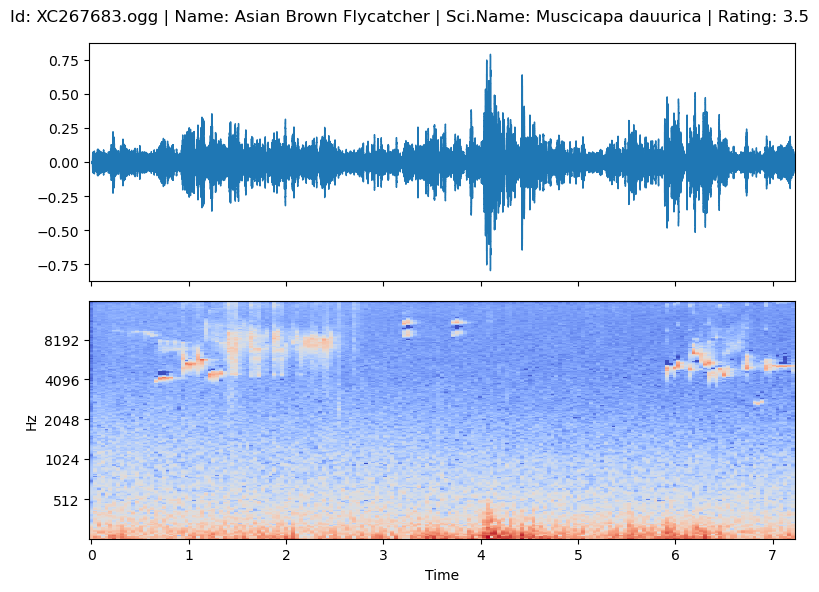

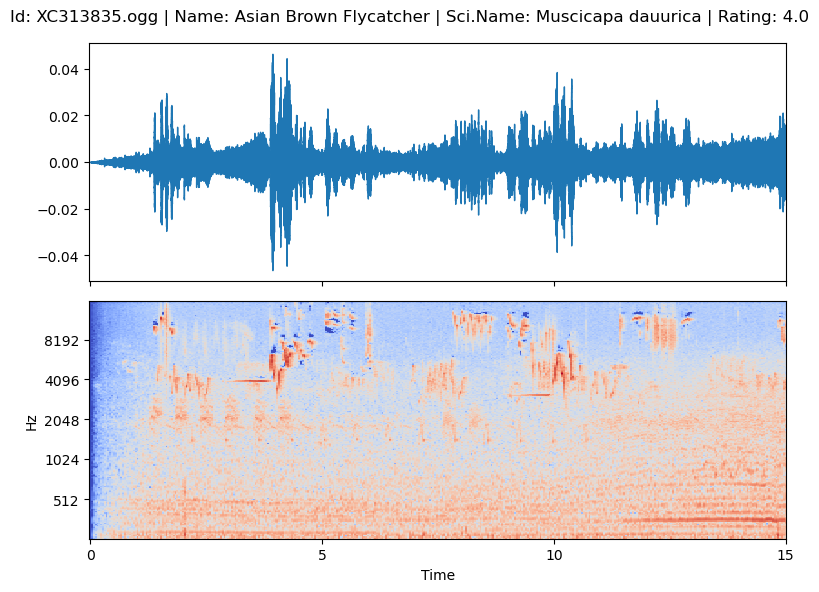

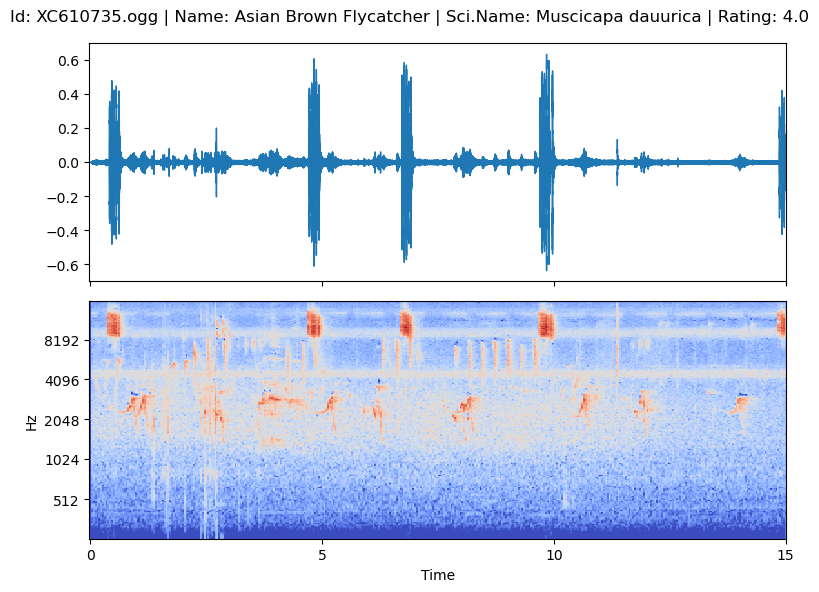

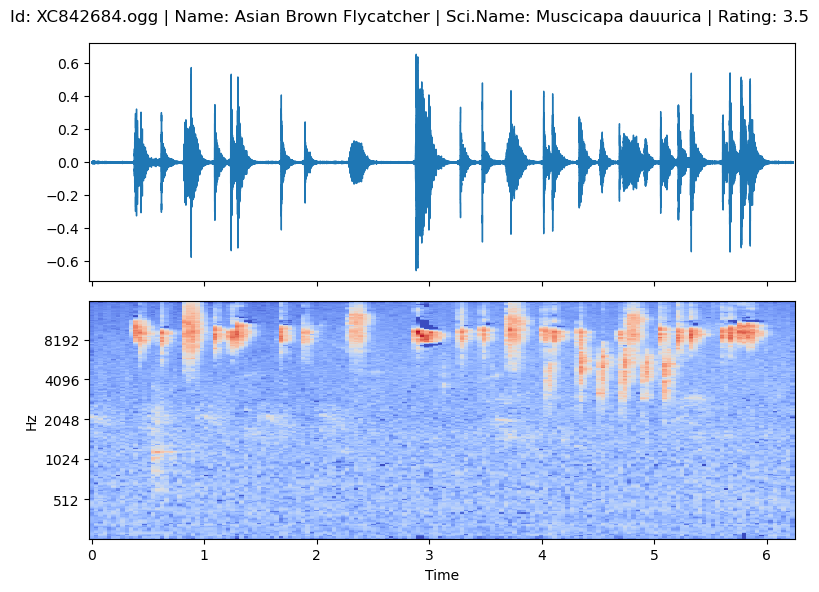

In [ ]:
# Hangfájl betöltése és megjelenítése
display_audio(df.iloc[10])
display_audio(df.iloc[15])
display_audio(df.iloc[50])
display_audio(df.iloc[100])